##### TODO
- [ ] Clear distinction between PCA between groups and between TR vs non-TR
- [ ] Rewrite the PCA with clustering (2D and 3D) to properly explore the results, apply to TR vs non
- [ ] Plot in 2D PC1 vs PC3 and PC2 vs PC3. Plot all conditions in one plot, use a color per condition
- [ ] Fix legends with alpha (remove it), maybe choose better colors and shapes and sizes of the dp

__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from matplotlib.lines import Line2D  # matplotlib custom lines
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
from scipy import stats  # statistical tests
from sklearn.decomposition import PCA  # principal component analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # run LDA
from sklearn.preprocessing import StandardScaler  # scale data before PCA
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (20, 8)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

"""
Event1: 1162-1400
Event2: 1958-2080
Event3: 2596-2890
"""
event_ranges = [(1162, 1400), (1958, 2080), (2596, 2890)]

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Read participants cleaned data__

In [3]:
parts = pd.read_csv("./participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

,date,expo,side,condition,nulls_%,sky_%,insidecar_%,questionnaire
id,,,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,1.610,13.740,2.359,No
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,0.037,0.674,25.421,No
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,0.037,33.134,0.786,No
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,0.824,18.607,2.845,No
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,0.225,26.994,0.262,No
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,0.300,32.160,0.000,No
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,0.674,15.462,5.054,No
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,1.797,3.370,11.718,No


In [4]:
quests = pd.read_csv("./questionnaires.csv", keep_default_na=False)
quests = quests.set_index("id")  # set uid column as index (remove default)
quests

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,side,condition
id,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,right,RadioTalk
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,left,RadioTalk
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,right,RadioTalk
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,right,TaxiDriver
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,right,RadioTalk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,right,RadioTalk
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,right,TaxiDriver
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,right,RadioTalk


In [5]:
hit_levs = pd.read_csv(f"./group_lengths.csv", index_col=0)
hit_levs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,18.414,0.924,1.122,1.881,3.597,18.282,0.000,0.000,1.155,13.332,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,0.000,28.677,0.297,30.360,0.000,0.000,0.363,4.620,0.000
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.000,0.627,0.924,0.000,0.000,0.000,0.363,9.207,0.000
37d7e67934974217830bb429bba7fd76,17.259,2.508,1.122,4.719,5.049,1.122,0.330,0.000,2.013,18.777,0.000
42bac596059749b5b8e8e83ae61de9b4,34.584,0.000,0.000,0.528,6.402,0.000,0.000,0.000,2.310,10.362,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,0.000,6.435,2.739,0.000,0.000,0.000,1.023,8.382,0.000
611d35a7c3e940cc82495e53c2a8532d,19.041,0.000,0.000,24.288,4.686,2.838,0.000,0.000,1.056,9.174,0.363
3b6fda285d9e412eb081986b2f22a2e3,7.821,0.000,0.462,18.381,0.660,16.599,0.000,1.122,5.874,5.577,0.000
18ffb0abdc8642098c479380bfa533d1,14.718,0.264,0.000,5.478,4.950,6.402,0.000,0.000,1.485,11.418,0.627


In [6]:
hit_levs = hit_levs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_levs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,18.414,0.924,1.122,1.881,3.597,18.282,0.000,0.000,1.155,13.332,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,0.000,28.677,0.297,30.360,0.000,0.000,0.363,4.620,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.000,0.627,0.924,0.000,0.000,0.000,0.363,9.207,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,17.259,2.508,1.122,4.719,5.049,1.122,0.330,0.000,2.013,18.777,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,34.584,0.000,0.000,0.528,6.402,0.000,0.000,0.000,2.310,10.362,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,0.000,6.435,2.739,0.000,0.000,0.000,1.023,8.382,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,19.041,0.000,0.000,24.288,4.686,2.838,0.000,0.000,1.056,9.174,0.363,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,7.821,0.000,0.462,18.381,0.660,16.599,0.000,1.122,5.874,5.577,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,14.718,0.264,0.000,5.478,4.950,6.402,0.000,0.000,1.485,11.418,0.627,BMBF,left,RadioTalk,Yes


In [7]:
display(hit_levs.describe())

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
count,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000,24356.000
mean,15.159,0.441,0.274,20.542,2.607,10.988,0.029,0.031,1.162,7.226,0.171
std,13.156,0.842,0.517,18.498,2.724,12.850,0.142,0.169,1.306,3.626,0.553
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.838,0.000,0.000,5.643,0.363,1.749,0.000,0.000,0.000,4.224,0.000
50%,12.804,0.000,0.000,14.454,1.815,6.831,0.000,0.000,0.792,6.633,0.000
75%,24.816,0.561,0.396,31.779,4.026,15.312,0.000,0.000,1.749,9.471,0.000
max,59.136,9.636,9.702,88.143,21.549,82.071,3.267,4.818,15.741,24.090,7.557


Final Groups

In [8]:
final_groups = ["Buildings", "Inside Car", "Nature", "condition"]
# length
gaze_levs = hit_levs[final_groups]
gaze_levs["Cars and Pedestrians"] = (
    hit_levs["Dynamic Cars"] + hit_levs["Dynamic Pedestrians"]
)
gaze_levs["Roads"] = hit_levs["Static Cars"] + hit_levs["Roads"]
gaze_levs["Street Objects"] = (
    hit_levs["Street Objects"] + hit_levs["Static Pedestrians"]
)
gaze_levs["Traffic Signs"] = (
    hit_levs["Traffic Signs"] + hit_levs["Traffic Lights"]
)

# TR vs non-TR
gaze_ltr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ltr["TR"] = (
    gaze_levs["Cars and Pedestrians"]
    + gaze_levs["Roads"]
    + gaze_levs["Traffic Signs"]
)
gaze_ltr["non-TR"] = (
    gaze_levs["Buildings"] + gaze_levs["Nature"] + gaze_levs["Street Objects"]
)
gaze_ltr["condition"] = gaze_levs["condition"]

In [9]:
def scatter_matrix(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    scaled = pd.DataFrame(data=x, columns=features)
    display(scaled)
    scaled_full = pd.concat([scaled, df.reset_index()[target]], axis=1)
    display(scaled_full)

    # ax = sns.pairplot(scaled_full, hue="condition", plot_kws={"alpha": 0.01})
    ax = sns.pairplot(
        scaled_full,
        hue="condition",
        kind="reg",
        # plot_kws={"levels": 1},
        plot_kws={"scatter_kws": {"alpha": 0.01}},
        corner=True,
    )
    for lh in ax._legend.legendHandles:
        lh.set_alpha(1)
    # ax.set(xlim=[-3,1], ylim=[-1,1])
    plt.show()

In [10]:
def pca_scatter_matrix(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    scaled = pd.DataFrame(data=x, columns=features)
    display(scaled)
    scaled_full = pd.concat([scaled, df.reset_index()[target]], axis=1)
    display(scaled_full)

    # prepare 2D PCA projection
    pca = PCA()
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(
        data=principalComponents,
        columns=["PC1", "PC2"],
    )

    # ax = sns.pairplot(scaled_full, hue="condition", plot_kws={"alpha": 0.01})
    ax = sns.pairplot(scaled_full, hue="condition", kind="kde")
    plt.show()

Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.247,-1.009,0.363,1.219,0.565,-0.029,1.561
1,-1.152,0.440,-0.848,-0.111,1.505,-0.620,-0.730
2,1.760,-1.077,-0.618,-0.655,-0.857,-0.620,0.476
3,0.160,-0.855,0.896,2.670,-0.744,0.613,2.992
4,1.477,-1.082,1.393,-0.655,-0.857,0.835,0.780
...,...,...,...,...,...,...,...
24351,1.436,-0.763,0.048,-0.655,-0.857,-0.127,0.259
24352,0.295,0.203,0.763,-0.655,-0.636,-0.102,0.563
24353,-0.558,-0.117,-0.715,-0.232,0.434,4.336,-0.478
24354,-0.033,-0.814,0.860,-0.413,-0.359,0.218,1.222


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs,condition
0,0.247,-1.009,0.363,1.219,0.565,-0.029,1.561,TaxiDriver
1,-1.152,0.440,-0.848,-0.111,1.505,-0.620,-0.730,AVAS
2,1.760,-1.077,-0.618,-0.655,-0.857,-0.620,0.476,RadioTalk
3,0.160,-0.855,0.896,2.670,-0.744,0.613,2.992,AVAS
4,1.477,-1.082,1.393,-0.655,-0.857,0.835,0.780,TaxiDriver
...,...,...,...,...,...,...,...,...
24351,1.436,-0.763,0.048,-0.655,-0.857,-0.127,0.259,AVAS
24352,0.295,0.203,0.763,-0.655,-0.636,-0.102,0.563,TaxiDriver
24353,-0.558,-0.117,-0.715,-0.232,0.434,4.336,-0.478,AVAS
24354,-0.033,-0.814,0.860,-0.413,-0.359,0.218,1.222,RadioTalk


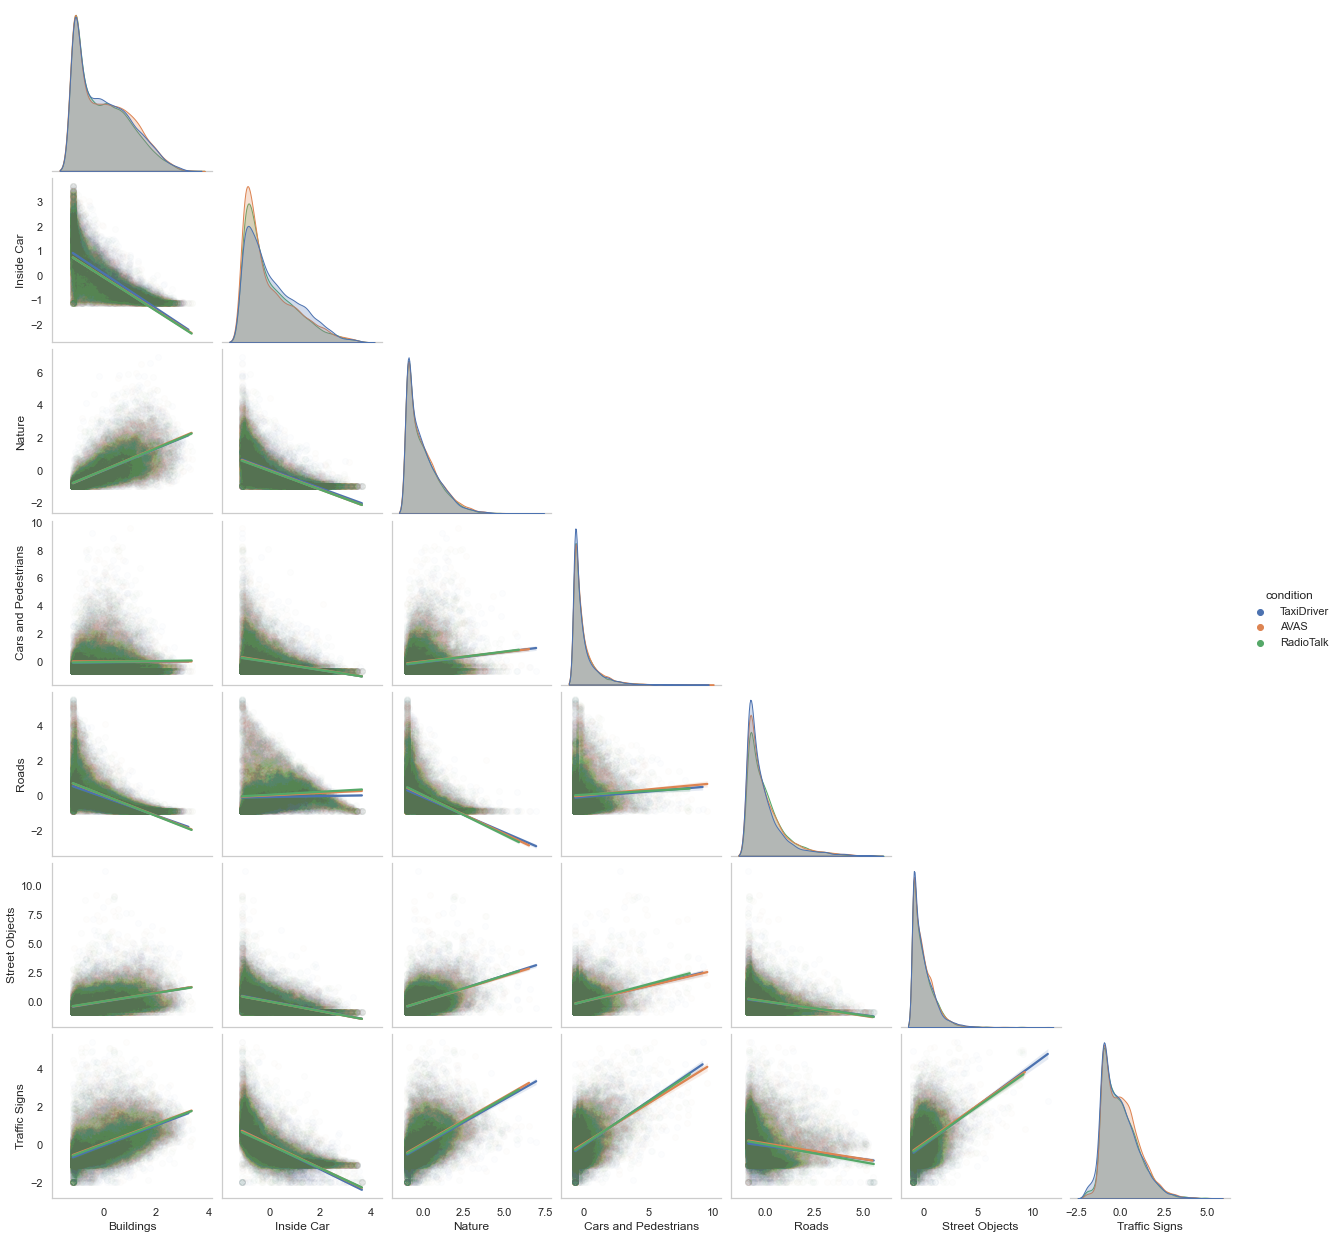

In [11]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(100, 100))
# set non-interactive plot (default)
%matplotlib inline
scatter_matrix(gaze_levs, "(gaze lengthts)")
# scatter_matrix(gaze_cevs, "(gaze counts)")

__PCA all components__

In [12]:
def pca_full(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    scaled = pd.DataFrame(data=x, columns=features)
    display(scaled)

    # prepare 2D PCA projection
    pca = PCA()
    pca = pca.fit(x)
    loadings = pca.components_
    num_pc = pca.n_features_
    pc_list = [f"PC{i}" for i in list(range(1, num_pc + 1))]
    loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
    loadings_df["variable"] = scaled.columns.values
    loadings_df = loadings_df.set_index("variable")
    display(loadings_df)

    # plt.figure(figsize=(10, 8))
    # ax = sns.heatmap(loadings_df, annot=True, cmap="Spectral")

    from bioinfokit.visuz import cluster

    # cluster.screeplot(obj=[pc_list, pca.explained_variance_ratio_])
    # get PCA loadings plots (2D and 3D)
    # 2D
    cluster.pcaplot(
        x=loadings[0],
        y=loadings[1],
        labels=scaled.columns.values,
        var1=round(pca.explained_variance_ratio_[0] * 100, 2),
        var2=round(pca.explained_variance_ratio_[1] * 100, 2),
    )

    # 3D
    cluster.pcaplot(
        x=loadings[0],
        y=loadings[1],
        z=loadings[2],
        labels=scaled.columns.values,
        var1=round(pca.explained_variance_ratio_[0] * 100, 2),
        var2=round(pca.explained_variance_ratio_[1] * 100, 2),
        var3=round(pca.explained_variance_ratio_[2] * 100, 2),
    )
    plt.show()
    print(f"PCA variance ({pc_list}): {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_)}")

__Compute and project PCA (2D, 2 components) over subjects__

In [13]:
np.set_printoptions(suppress=True)

# set non-interactive plot (default)
%matplotlib inline
print("PCA full over subjects for gaze lengthts:")
pca_full(gaze_levs, "(gaze lengthts)")

PCA full over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.247,-1.009,0.363,1.219,0.565,-0.029,1.561
1,-1.152,0.440,-0.848,-0.111,1.505,-0.620,-0.730
2,1.760,-1.077,-0.618,-0.655,-0.857,-0.620,0.476
3,0.160,-0.855,0.896,2.670,-0.744,0.613,2.992
4,1.477,-1.082,1.393,-0.655,-0.857,0.835,0.780
...,...,...,...,...,...,...,...
24351,1.436,-0.763,0.048,-0.655,-0.857,-0.127,0.259
24352,0.295,0.203,0.763,-0.655,-0.636,-0.102,0.563
24353,-0.558,-0.117,-0.715,-0.232,0.434,4.336,-0.478
24354,-0.033,-0.814,0.860,-0.413,-0.359,0.218,1.222


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
Buildings,0.460,-0.309,-0.230,-0.123,-0.144,-0.342,0.698
Inside Car,-0.437,-0.191,0.500,-0.086,-0.015,0.441,0.566
Nature,0.443,-0.179,-0.041,0.048,0.755,0.445,-0.003
Cars and Pedestrians,0.193,0.630,0.458,-0.419,0.266,-0.301,0.136
Roads,-0.259,0.579,-0.514,0.346,0.170,0.120,0.413
Street Objects,0.349,0.118,0.462,0.785,-0.173,-0.048,0.054
Traffic Signs,0.419,0.298,-0.095,-0.252,-0.529,0.619,-0.026


PCA variance (['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']): [0.48555495 0.19347451 0.11282497 0.08962552 0.05575388 0.04745128
 0.01531489]
Total variance explained: 1.0


In [25]:
np.set_printoptions(suppress=True)

# set non-interactive plot (default)
%matplotlib inline
print("PCA full over subjects for gaze lengthts:")
pca_full(gaze_levs[gaze_levs.condition == "TaxiDriver"], "(gaze lengthts)")

PCA full over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.240,-1.092,0.374,1.266,0.650,-0.015,1.611
1,1.467,-1.165,1.407,-0.635,-0.803,0.845,0.834
2,1.514,-1.193,0.921,-0.635,-0.803,-0.113,0.462
3,2.778,-1.193,1.043,-0.635,-0.803,0.476,1.499
4,0.368,-0.639,0.605,-0.635,-0.698,0.280,-0.004
...,...,...,...,...,...,...,...
8192,0.503,-0.250,-0.501,-0.635,-0.709,1.483,-0.600
8193,0.450,-0.167,0.569,-0.635,-0.803,-0.236,-0.220
8194,2.671,-1.193,0.945,-0.635,-0.803,1.360,0.454
8195,0.288,0.106,0.775,-0.635,-0.578,-0.089,0.618


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
Buildings,0.459,-0.309,-0.239,-0.145,-0.160,-0.346,-0.685
Inside Car,-0.444,-0.195,0.482,-0.028,0.017,0.426,-0.591
Nature,0.440,-0.189,-0.040,0.044,0.783,0.393,0.003
Cars and Pedestrians,0.198,0.610,0.508,-0.397,0.241,-0.312,-0.134
Roads,-0.237,0.601,-0.526,0.318,0.194,0.082,-0.400
Street Objects,0.351,0.095,0.411,0.815,-0.166,-0.065,-0.051
Traffic Signs,0.424,0.298,-0.067,-0.230,-0.488,0.660,0.001


PCA variance (['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']): [0.48561072 0.1946569  0.11361408 0.09056522 0.05674779 0.04462196
 0.01418334]
Total variance explained: 1.0000000000000002


__PCA and LDA 2D (2 components) functions__

In [14]:
def pca_2d(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    display(pd.DataFrame(data=x, columns=features).head())

    # prepare 2D PCA projection
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(
        data=principalComponents,
        columns=["PC1", "PC2"],
    )
    print("Preview projected values:")
    display(principalDf.head(5))
    print("Include target value:")
    finalDf = pd.concat([principalDf, df.reset_index()[target]], axis=1)
    display(finalDf.head(5))

    # visualize the 2D projected data
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("PC1", fontsize=15)
    ax.set_ylabel("PC2", fontsize=15)
    ax.set_title(f"2 Component PCA {title}", fontsize=20)
    targets = df.condition.unique()
    colors = ["r", "g", "b"]
    for target, color in zip(targets, colors):
        indicesToKeep = finalDf["condition"] == target
        ax.scatter(
            finalDf.loc[indicesToKeep, "PC1"],
            finalDf.loc[indicesToKeep, "PC2"],
            c=color,
            s=50,
            alpha=0.01,
        )
    ax.legend(targets)
    ax.grid()
    plt.show()
    # show the variance explained by the componentsc
    print(f"PCA variance ([PC1, PC2]): {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_)}")


def lda_2d(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    display(pd.DataFrame(data=x, columns=features).head())

    # prepare 2D LDA projection
    lda = LinearDiscriminantAnalysis(n_components=2)
    x = lda.fit_transform(x, y)
    ldaDf = pd.DataFrame(
        data=x,
        columns=["LD1", "LD2"],
    )
    print("Preview projected values:")
    display(ldaDf.head(5))
    print("Include target value:")
    ldaDf = pd.concat([ldaDf, df.reset_index()[target]], axis=1)
    display(ldaDf.head(5))

    # visualize the 2D projected data
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("LD1", fontsize=15)
    ax.set_ylabel("LD2", fontsize=15)
    ax.set_title(f"2 Component LDA {title}", fontsize=20)
    targets = df.condition.unique()
    colors = ["r", "g", "b"]
    for target, color in zip(targets, colors):
        indicesToKeep = ldaDf["condition"] == target
        ax.scatter(
            ldaDf.loc[indicesToKeep, "LD1"],
            ldaDf.loc[indicesToKeep, "LD2"],
            c=color,
            s=50,
            alpha=0.01,
        )
    ax.legend(targets)
    ax.grid()
    plt.show()
    # show the variance explained by the componentsc
    print(f"LDA variance ([LD1, LD2]): {lda.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(lda.explained_variance_ratio_)}")

__PCA and LDA 3D (3 components) functions__

In [15]:
def pca_3d(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    display(pd.DataFrame(data=x, columns=features).head())

    # prepare 3D PCA projection
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(
        data=principalComponents,
        columns=["PC1", "PC2", "PC3"],
    )
    print("Preview projected values:")
    display(principalDf.head(5))
    print("Include target value:")
    finalDf = pd.concat([principalDf, df.reset_index()[target]], axis=1)
    display(finalDf.head(5))

    # visualize the 3D projected data
    Xax = finalDf.PC1
    Yax = finalDf.PC2
    Zax = finalDf.PC3

    targets = df.condition.unique()
    cdict = {targets[0]: "red", targets[1]: "green", targets[2]: "blue"}
    labl = {
        targets[0]: targets[0],
        targets[1]: targets[1],
        targets[2]: targets[2],
    }
    marker = {targets[0]: "o", targets[1]: "o", targets[2]: "o"}
    alpha = {targets[0]: 0.01, targets[1]: 0.01, targets[2]: 0.01}

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    fig.patch.set_facecolor("white")
    for l in targets:
        ix = finalDf[finalDf.condition == l].index
        ax.scatter(
            Xax[ix],
            Yax[ix],
            Zax[ix],
            c=cdict[l],
            s=40,
            label=labl[l],
            marker=marker[l],
            alpha=alpha[l],
        )
    # for loop ends
    ax.set_xlabel("PC1", fontsize=14)
    ax.set_ylabel("PC2", fontsize=14)
    ax.set_zlabel("PC3", fontsize=14)
    plt.legend()
    plt.show()
    # show the variance explained by the componentsc
    print(f"PCA variance ([PC1, PC2, PC3]): {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_)}")


def lda_3d(df, title):
    # standarize the data
    features = df.columns.tolist()
    # remove target value (condition)
    features.remove("condition")
    # store target variable
    target = ["condition"]
    # features vector
    x = df.loc[:, features].values
    # target vector
    y = df.loc[:, target].values
    x = StandardScaler().fit_transform(x)
    print("Preview scaled data:")
    display(pd.DataFrame(data=x, columns=features).head())

    # prepare 3D LDA projection
    lda = LinearDiscriminantAnalysis(n_components=3)
    x = lda.fit_transform(x, y)
    ldaDf = pd.DataFrame(
        data=x,
        columns=["LD1", "LD2", "LD3"],
    )
    print("Preview projected values:")
    display(ldaDf.head(5))
    print("Include target value:")
    ldaDf = pd.concat([ldaDf, df.reset_index()[target]], axis=1)
    display(ldaDf.head(5))

    # visualize the 3D projected data
    Xax = ldaDf.LD1
    Yax = ldaDf.LD2
    Zax = ldaDf.LD3

    targets = df.condition.unique()
    cdict = {targets[0]: "red", targets[1]: "green", targets[2]: "blue"}
    labl = {
        targets[0]: targets[0],
        targets[1]: targets[1],
        targets[2]: targets[2],
    }
    marker = {targets[0]: "o", targets[1]: "o", targets[2]: "o"}
    alpha = {targets[0]: 0.01, targets[1]: 0.01, targets[2]: 0.01}

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    fig.patch.set_facecolor("white")
    for l in targets:
        ix = ldaDf[ldaDf.condition == l].index
        ax.scatter(
            Xax[ix],
            Yax[ix],
            Zax[ix],
            c=cdict[l],
            s=40,
            label=labl[l],
            marker=marker[l],
            alpha=alpha[l],
        )
    # for loop ends
    ax.set_xlabel("LD1", fontsize=14)
    ax.set_ylabel("LD2", fontsize=14)
    ax.set_zlabel("LD3", fontsize=14)
    plt.legend()
    plt.show()
    # show the variance explained by the componentsc
    print(f"LDA variance ([LD1, LD2, LD3]): {lda.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(lda.explained_variance_ratio_)}")

__Compute and project PCA (2D, 2 components) over subjects__

PCA 2D over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.247,-1.009,0.363,1.219,0.565,-0.029,1.561
1,-1.152,0.440,-0.848,-0.111,1.505,-0.620,-0.730
2,1.760,-1.077,-0.618,-0.655,-0.857,-0.620,0.476
3,0.160,-0.855,0.896,2.670,-0.744,0.613,2.992
4,1.477,-1.082,1.393,-0.655,-0.857,0.835,0.780


Preview projected values:


,PC1,PC2
0,1.448,1.610
1,-2.031,0.934
2,1.086,-1.068
3,3.018,2.172
4,2.483,-1.077


Include target value:


,PC1,PC2,condition
0,1.448,1.610,TaxiDriver
1,-2.031,0.934,AVAS
2,1.086,-1.068,RadioTalk
3,3.018,2.172,AVAS
4,2.483,-1.077,TaxiDriver


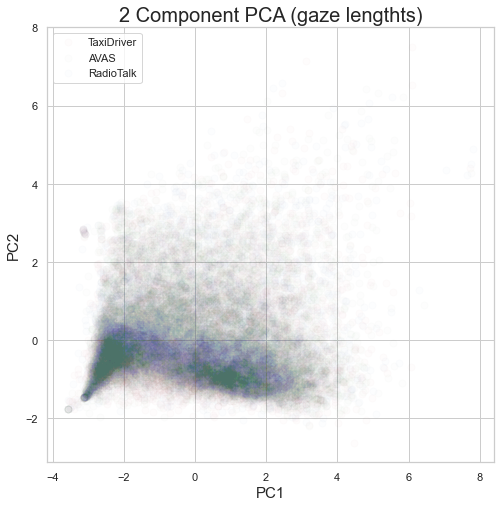

PCA variance ([PC1, PC2]): [0.48555495 0.19347451]
Total variance explained: 0.6790294578362774


In [16]:
# set non-interactive plot (default)
%matplotlib inline
print("PCA 2D over subjects for gaze lengthts:")
pca_2d(gaze_levs, "(gaze lengthts)")

PCA 2D over subjects for gaze lengthts:
Preview scaled data:


,TR,non-TR
0,1.114,0.268
1,1.260,-1.164
2,-0.760,1.313
3,0.363,0.341
4,-0.672,1.548


Preview projected values:


,PC1,PC2
0,0.598,0.977
1,1.714,0.068
2,-1.466,0.391
3,0.015,0.498
4,-1.570,0.620


Include target value:


,PC1,PC2,condition
0,0.598,0.977,TaxiDriver
1,1.714,0.068,AVAS
2,-1.466,0.391,RadioTalk
3,0.015,0.498,AVAS
4,-1.570,0.620,TaxiDriver


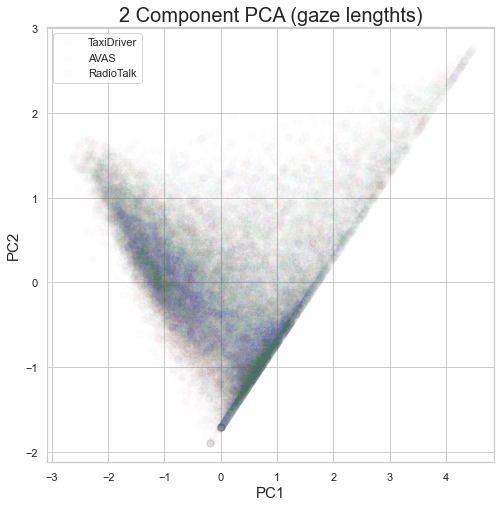

PCA variance ([PC1, PC2]): [0.69942354 0.30057646]
Total variance explained: 1.0


In [17]:
print("PCA 2D over subjects for gaze lengthts:")
pca_2d(gaze_ltr, "(gaze lengthts)")

__Compute and project PCA (3D, 3 components) over subjects__

PCA 3D over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.247,-1.009,0.363,1.219,0.565,-0.029,1.561
1,-1.152,0.440,-0.848,-0.111,1.505,-0.620,-0.730
2,1.760,-1.077,-0.618,-0.655,-0.857,-0.620,0.476
3,0.160,-0.855,0.896,2.670,-0.744,0.613,2.992
4,1.477,-1.082,1.393,-0.655,-0.857,0.835,0.780


Preview projected values:


,PC1,PC2,PC3
0,1.448,1.610,-0.470
1,-2.031,0.934,-0.522
2,1.086,-1.068,-1.108
3,3.018,2.172,1.102
4,2.483,-1.077,-0.485


Include target value:


,PC1,PC2,PC3,condition
0,1.448,1.610,-0.470,TaxiDriver
1,-2.031,0.934,-0.522,AVAS
2,1.086,-1.068,-1.108,RadioTalk
3,3.018,2.172,1.102,AVAS
4,2.483,-1.077,-0.485,TaxiDriver


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
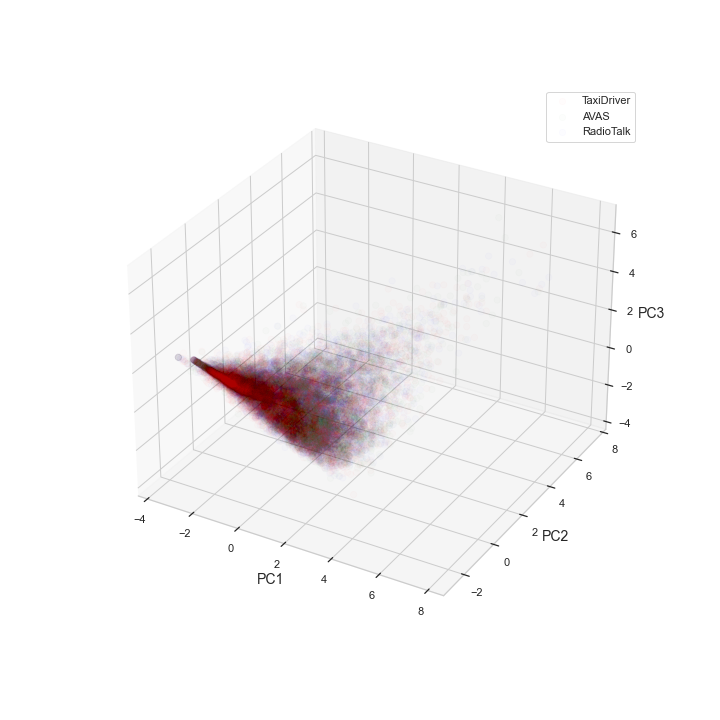

PCA variance ([PC1, PC2, PC3]): [0.48555495 0.19347451 0.11282497]
Total variance explained: 0.7918544239909141


In [18]:
# set interactive plot
%matplotlib widget
print("PCA 3D over subjects for gaze lengthts:")
pca_3d(gaze_levs, "(gaze lengthts)")

PCA 3D over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.247,-1.009,0.363,1.219,0.565,-0.029,1.561
1,-1.152,0.440,-0.848,-0.111,1.505,-0.620,-0.730
2,1.760,-1.077,-0.618,-0.655,-0.857,-0.620,0.476
3,0.160,-0.855,0.896,2.670,-0.744,0.613,2.992
4,1.477,-1.082,1.393,-0.655,-0.857,0.835,0.780


Preview projected values:


,PC1,PC2,PC3
0,1.448,1.610,-0.470
1,-2.031,0.934,-0.522
2,1.086,-1.068,-1.108
3,3.018,2.172,1.102
4,2.483,-1.077,-0.485


Include target value:


,PC1,PC2,PC3,condition
0,1.448,1.610,-0.470,TaxiDriver
1,-2.031,0.934,-0.522,AVAS
2,1.086,-1.068,-1.108,RadioTalk
3,3.018,2.172,1.102,AVAS
4,2.483,-1.077,-0.485,TaxiDriver


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
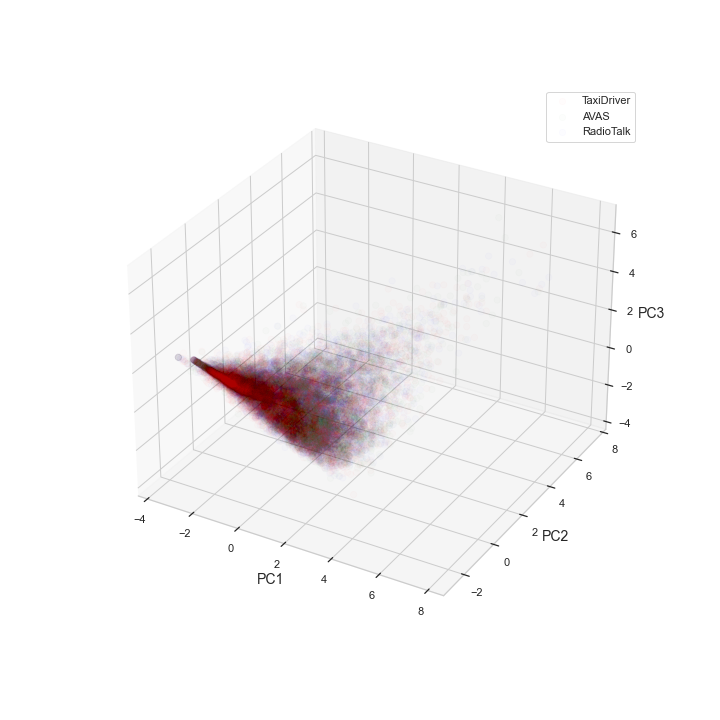

PCA variance ([PC1, PC2, PC3]): [0.48555495 0.19347451 0.11282497]
Total variance explained: 0.7918544239909141


In [19]:
# set interactive plot
%matplotlib widget
print("PCA 3D over subjects for gaze lengthts:")
pca_3d(gaze_levs, "(gaze lengthts)")

__Compute and project LDA (2D, 2 components) over subjects__

LDA 2D over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.247,-1.009,0.363,1.219,0.565,-0.029,1.561
1,-1.152,0.440,-0.848,-0.111,1.505,-0.620,-0.730
2,1.760,-1.077,-0.618,-0.655,-0.857,-0.620,0.476
3,0.160,-0.855,0.896,2.670,-0.744,0.613,2.992
4,1.477,-1.082,1.393,-0.655,-0.857,0.835,0.780


Preview projected values:


,LD1,LD2
0,-1.177,1.303
1,-0.541,-0.921
2,0.049,1.093
3,-1.051,2.398
4,-0.131,0.680


Include target value:


,LD1,LD2,condition
0,-1.177,1.303,TaxiDriver
1,-0.541,-0.921,AVAS
2,0.049,1.093,RadioTalk
3,-1.051,2.398,AVAS
4,-0.131,0.680,TaxiDriver


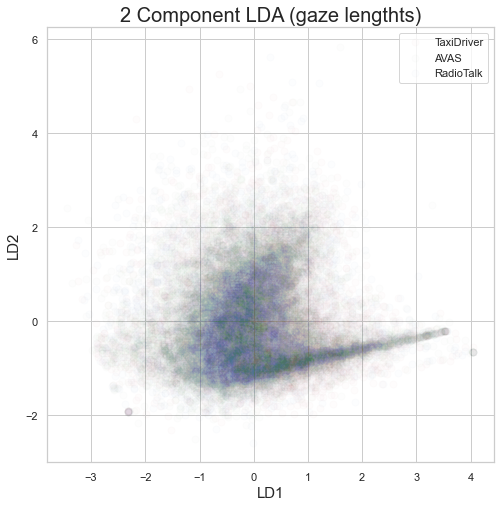

LDA variance ([LD1, LD2]): [0.89868923 0.10131077]
Total variance explained: 1.0


In [20]:
# set non-interactive plot (default)
%matplotlib inline
print("LDA 2D over subjects for gaze lengthts:")
lda_2d(gaze_levs, "(gaze lengthts)")

LDA 2D over subjects for gaze lengthts:
Preview scaled data:


,TR,non-TR
0,1.114,0.268
1,1.260,-1.164
2,-0.760,1.313
3,0.363,0.341
4,-0.672,1.548


Preview projected values:


,LD1,LD2
0,-1.331,0.283
1,-0.884,-1.154
2,0.274,1.310
3,-0.541,0.347
4,0.078,1.548


Include target value:


,LD1,LD2,condition
0,-1.331,0.283,TaxiDriver
1,-0.884,-1.154,AVAS
2,0.274,1.310,RadioTalk
3,-0.541,0.347,AVAS
4,0.078,1.548,TaxiDriver


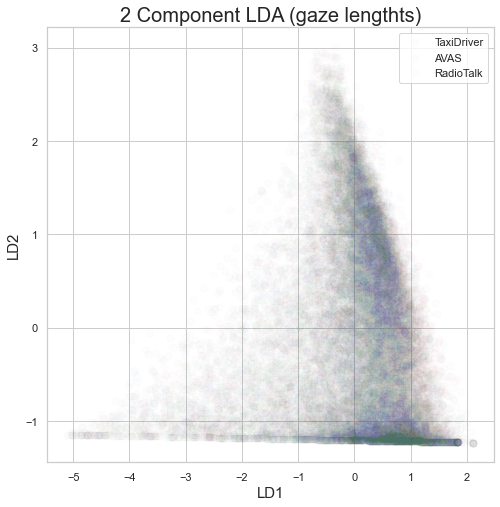

LDA variance ([LD1, LD2]): [0.88399237 0.11600763]
Total variance explained: 1.0


In [21]:
print("LDA 2D over subjects for gaze lengthts:")
lda_2d(gaze_ltr, "(gaze lengthts)")

__Compute and project LDA (3D, 3 components) over subjects__

In [22]:
# set interactive plot
%matplotlib widget
print("PCA 3D over subjects for gaze lengthts:")
lda_3d(gaze_levs, "(gaze lengthts)")

PCA 3D over subjects for gaze lengthts:
Preview scaled data:


,Buildings,Inside Car,Nature,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
0,0.247,-1.009,0.363,1.219,0.565,-0.029,1.561
1,-1.152,0.440,-0.848,-0.111,1.505,-0.620,-0.730
2,1.760,-1.077,-0.618,-0.655,-0.857,-0.620,0.476
3,0.160,-0.855,0.896,2.670,-0.744,0.613,2.992
4,1.477,-1.082,1.393,-0.655,-0.857,0.835,0.780


ValueError: n_components cannot be larger than min(n_features, n_classes - 1).